<a href="https://colab.research.google.com/github/ssnirgudkar/Datasetpaper-final/blob/main/deeplab2_Finalpaper_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Use this version as the most final

creates model folder automatically

to do - 
1. Batch size should be 10 (identical with UNet, PSPNet) - This batch size gives OOM. 7 is the max we can go with regular RAM - complete 
2. Image size 512*512 : Is this really needed? We are not using imagenet weights anyway. - Updted to use the actual - complete  
3. Shuffle the training and validation images. Use the code which was shared earlier. I think this will be beneficial. - complete 
4. the default setting in kears is channel last that maps to channels_last corresponds to inputs with shape (batch_size, height, width, channels) while channels_first corresponds to inputs with shape (batch_size, channels, height, width).So change the ordering to always put height, width.  

## we have to keep batchsize = 2 or more. It does not run with batch size 1. Image will be resized to 512*512
## mask datatype is uint8. segments.ai semantic masks are uint8 and instance masks are uint16. We need to be careful about which type of masks are getting processed else it reads masks as 0. 
##the resize was changed to nearest. but we can check if thats needed. bilinear is default. So we can try to keep it as bilinera and that shld also work. With this run, objects were not coming up well. objects and background was getting mixed

Run2 11/11 - Uncommented the 127.5-1 code. so now both image and masks are float 32. also changed the nearest back to bilnear. changed the batch size from 10 to 4. running with 50 epochs to see how it works.

Train images - 
Val images - 
Test images 
Epochs - 500 
Train time -

##Run3 - 
Train images - 3438
Val images - 982
Test images - 492
Epochs - 50 
Train time - 3 hrs 49 min
Test time - 
Any preloaded weights - NO. Imagenet weights are not used
The masks are uint8. the code had it as uint16. Hence we were getting pixel values of 257. fixed that
Model - deeplab-finalpapersubmission_V1

##Run4 - 
Train images - 26081
Val images - 7452
Test images - 3726
Epochs - 25(will break into 4 parts as this is a big dataset.  
Train time - 10 hrs 40 min
Test time - 
Any preloaded weights - NO. Imagenet weights are not used
Model - deeplab-finalpapersubmission (the next ones will be submission2,3 and 4)
infernce folder - IRDatasetFinal-Inferences
loss: 0.0623 - accuracy: 0.9790 

##Run5 - 2020 & 2021
loss: 0.0361 - accuracy: 0.9873 - val_loss: 3.3841 - val_accuracy: 0.7209
epochs - 50 
ran with 2020 and 2021 dataset only 
Model - deeplab folder - deeplab-finalpapersubmission-2020only (there's another with 2020-only. need to check)
training time - 9 hrs, 27 min

# https://keras.io/examples/vision/deeplabv3_plus/

In [1]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetConsolidated/train.zip", "r")
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/train.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetConsolidated/trainannot.zip", "r")
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/trainannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetConsolidated/val.zip", "r")
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/val.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetConsolidated/valannot.zip", "r")
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/valannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()
'''
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/test.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/testannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()
'''

'\nzip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/test.zip", "r")\nzip_ref.extractall("/content/IRDatasetFinal")\nzip_ref.close()\n\nzip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/testannot.zip", "r")\nzip_ref.extractall("/content/IRDatasetFinal")\nzip_ref.close()\n'

In [3]:
import os 
APP_FOLDER = '/content/IRDatasetFinal/train'
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
   

print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  /content/IRDatasetFinal/train
Total number of files 27678
Total Number of directories 0
Total: 27678


In [4]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Downloading the data We will use the Crowd Instance-level Human Parsing Dataset for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images. Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification. This dataset can be used for the "human part segmentation" task.

In [ ]:
#!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
#!unzip -q instance-level-human-parsing.zip

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
# to copy files from google drive to colab memory
#%cp -av /content/drive/MyDrive/TheIRDatasetMini/ TheIRDatasetMini
'''

Mounted at /content/drive


In [ ]:
IMAGE_SIZE_WIDTH = 640
IMAGE_SIZE_HEIGHT = 512
BATCH_SIZE = 7
NUM_CLASSES = 7
#DATA_DIR = '/content/drive/MyDrive/TheIRDatasetMini_backup'
DATA_DIR = '/content/IRDatasetFinal'
#DATA_DIR = '/content/drive/MyDrive/TheIRDataset'
#DATA_DIR = '/content/drive/MyDrive/IR -test'

#VAL_DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
#NUM_TRAIN_IMAGES = 80
#NUM_VAL_IMAGES = 10

'''
train_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "trainannot/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "trainannot/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
'''
train_images = sorted(glob(os.path.join(DATA_DIR, "train/*"))) 
train_masks = sorted(glob(os.path.join(DATA_DIR, "trainannot/*"))) 
indices_train = random.sample(range(len(train_images)), len(train_images))
train_images = list(map(train_images.__getitem__, indices_train))
train_masks = list(map(train_masks.__getitem__, indices_train))
print("type of train_images = ", type(train_images))

val_images = sorted(glob(os.path.join(DATA_DIR, "val/*")))
val_masks = sorted(glob(os.path.join(DATA_DIR, "valannot/*")))
indices_val = random.sample(range(len(val_images)), len(val_images))
val_images = list(map(val_images.__getitem__, indices_val))
val_masks = list(map(val_masks.__getitem__, indices_val))

#test_images = sorted(glob(os.path.join(DATA_DIR, "test/*")))
#test_masks = sorted(glob(os.path.join(DATA_DIR, "testannot/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    print("image=", image)
    if mask:
        image = tf.image.decode_png(image, channels=0, dtype=tf.uint8)
        #print("mask 1st read", image)
        #print("Max value of mask as per tef.reduce are", tf.reduce_max(image))
        image.set_shape([None, None, 1])
        #image = tf.cast(image, dtype=tf.float32)
        #print("mask 2nd read", image)
        image = tf.image.resize(images=image, method= 'nearest', size=[IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH])
        #print("mask 3rd read after resize", image)
        #print('final image' ,image)
        #print('unique values of tensor' , tf.unique(image))
    else:
        image = tf.image.decode_png(image, channels=3, dtype=tf.uint8)
        #print("1st step in read image", image)
        image.set_shape([None, None, 3])
        image = tf.cast(image, dtype=tf.float32)
        #print("2nd step in read image", image)
        image = tf.image.resize(images=image, method= 'bilinear', size=[IMAGE_SIZE_HEIGHT, IMAGE_SIZE_WIDTH])
        image = image / 127.5 - 1
        #print("image looks like", image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

read_image(train_masks[20], mask=True)

#print ((np.unique(cv2.imread(train_masks[1],cv2.IMREAD_UNCHANGED))))


#print("Train Dataset:", train_dataset)
#print("Val Dataset:", val_dataset)

In [ ]:
#print(train_masks)
print(train_images)
print(train_masks)

In [6]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [ ]:
def DeeplabV3Plus(image_size_height, image_size_width, num_classes):
    model_input = keras.Input(shape=(image_size_height, image_size_width, 3))
    resnet50 = keras.applications.ResNet50(
        #weights="imagenet", include_top=False, input_tensor=model_input - removed imagenet weights
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    print("x shape 1 value", x.shape[1] )
    print("x shape 2 value", x.shape[2] )

    print("size is", image_size_height // 4 // x.shape[1], image_size_width // 4 // x.shape[2])

    input_a = layers.UpSampling2D(
        size=(image_size_height // 4 // x.shape[1], image_size_width // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size_height // x.shape[1], image_size_width // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size_height=IMAGE_SIZE_HEIGHT,
                      image_size_width=IMAGE_SIZE_WIDTH, 
                      num_classes=NUM_CLASSES)
model.summary()

In [ ]:
#### This is the training cell
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

my_callbacks = [
    #tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Logs/Unet-7classes-finalpapersubmission'),
    #keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-20201only", save_freq = 'epoch', save_best_only=True)
    #keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-revisedcode-2020only", save_freq = 'epoch', save_best_only=True)
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled", monitor = 'loss', save_freq = 'epoch', save_best_only=True)
]
history = model.fit(train_dataset, validation_data=val_dataset, callbacks = my_callbacks, epochs=25)
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
#plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
#plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
#plt.show()

#model.save("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only")

model loaded
Epoch 1/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9835INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2075s 521ms/step - loss: 0.0441 - accuracy: 0.9835 - val_loss: 0.0852 - val_accuracy: 0.9745
Epoch 2/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9853INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2059s 521ms/step - loss: 0.0385 - accuracy: 0.9853 - val_loss: 0.0869 - val_accuracy: 0.9758
Epoch 3/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9861INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2046s 518ms/step - loss: 0.0359 - accuracy: 0.9861 - val_loss: 0.0855 - val_accuracy: 0.9771
Epoch 4/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9875INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2047s 518ms/step - loss: 0.0318 - accuracy: 0.9875 - val_loss: 0.0882 - val_accuracy: 0.9770
Epoch 5/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9881INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2059s 521ms/step - loss: 0.0303 - accuracy: 0.9881 - val_loss: 0.0926 - val_accuracy: 0.9774
Epoch 6/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9890INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2060s 521ms/step - loss: 0.0275 - accuracy: 0.9890 - val_loss: 0.0927 - val_accuracy: 0.9782
Epoch 7/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9891INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3954/3954 [==============================] - 2060s 521ms/step - loss: 0.0271 - accuracy: 0.9891 - val_loss: 0.0991 - val_accuracy: 0.9784


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 8/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9898INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2059s 521ms/step - loss: 0.0249 - accuracy: 0.9898 - val_loss: 0.0981 - val_accuracy: 0.9785
Epoch 9/20
3954/3954 [==============================] - 2034s 514ms/step - loss: 0.0250 - accuracy: 0.9899 - val_loss: 0.1020 - val_accuracy: 0.9786
Epoch 10/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9908INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2058s 520ms/step - loss: 0.0224 - accuracy: 0.9908 - val_loss: 0.0998 - val_accuracy: 0.9783
Epoch 11/20
3954/3954 [==============================] - 2033s 514ms/step - loss: 0.0229 - accuracy: 0.9907 - val_loss: 0.1009 - val_accuracy: 0.9780
Epoch 12/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9909INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2059s 521ms/step - loss: 0.0224 - accuracy: 0.9909 - val_loss: 0.1046 - val_accuracy: 0.9790
Epoch 13/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9918INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2043s 517ms/step - loss: 0.0196 - accuracy: 0.9918 - val_loss: 0.1071 - val_accuracy: 0.9790
Epoch 14/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9921INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2057s 520ms/step - loss: 0.0190 - accuracy: 0.9921 - val_loss: 0.1134 - val_accuracy: 0.9787
Epoch 15/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9921INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2041s 516ms/step - loss: 0.0189 - accuracy: 0.9921 - val_loss: 0.1013 - val_accuracy: 0.9781
Epoch 16/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9926INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2042s 516ms/step - loss: 0.0175 - accuracy: 0.9926 - val_loss: 0.1177 - val_accuracy: 0.9786
Epoch 17/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9928INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2040s 516ms/step - loss: 0.0170 - accuracy: 0.9928 - val_loss: 0.1283 - val_accuracy: 0.9781
Epoch 18/20
3954/3954 [==============================] - 2034s 514ms/step - loss: 0.0198 - accuracy: 0.9920 - val_loss: 0.1062 - val_accuracy: 0.9786
Epoch 19/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9932INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2041s 516ms/step - loss: 0.0162 - accuracy: 0.9932 - val_loss: 0.1211 - val_accuracy: 0.9789
Epoch 20/20
3954/3954 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9933INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3954/3954 [==============================] - 2040s 516ms/step - loss: 0.0158 - accuracy: 0.9933 - val_loss: 0.1299 - val_accuracy: 0.9783


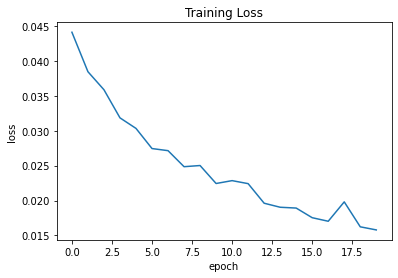

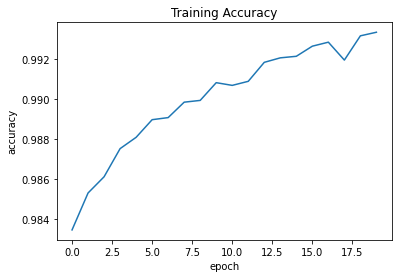

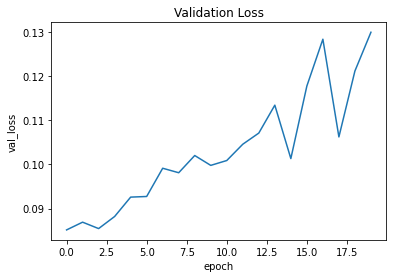

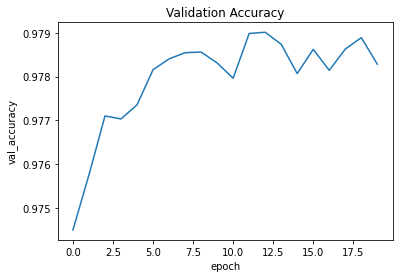

In [8]:
## this is to retrain the saved model - RUN#2
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled")
print("model loaded")

my_callbacks = [
    #tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Logs/Unet-7classes-finalpapersubmission'),
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled", monitor = 'loss', save_freq = 'epoch', save_best_only=True)

               ]

history = reconstructed_model.fit(train_dataset, validation_data=val_dataset, callbacks = my_callbacks, epochs=20)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

#commented below as checkpoint already has save best. else it will create a duplicate
#print("model to be saved")
#reconstructed_model.save("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only")
#print("model saved")